In [1]:
import ctypes
import numpy as np
import utility.Pi_util
import importlib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
importlib.reload(utility.Pi_util)
path: str = '/Volumes/EXTERNAL1/allSensorsCPP/'
results: dict = utility.Pi_util.parse_chunks_binary(path)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ctypeslib.py:540: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ctypeslib.py:540: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ctypeslib.py:540: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)
/Library/Frameworks/Python.fram

In [ ]:
print(results)

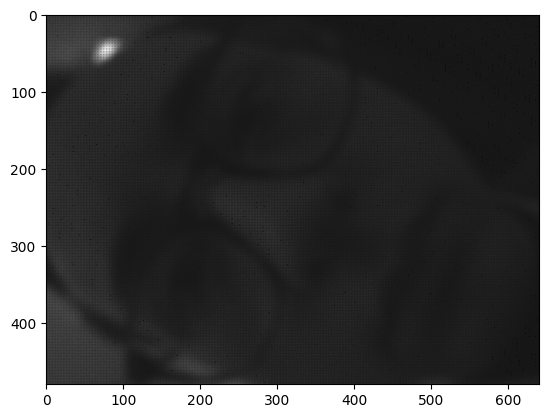

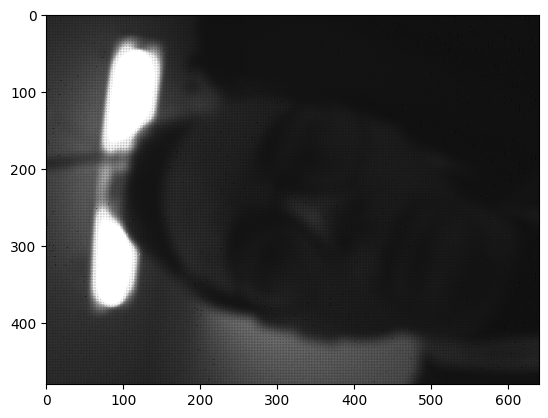

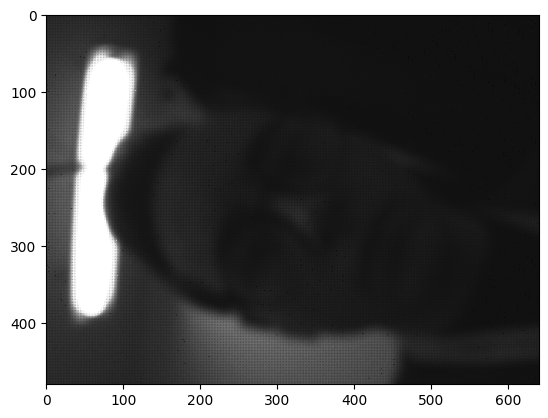

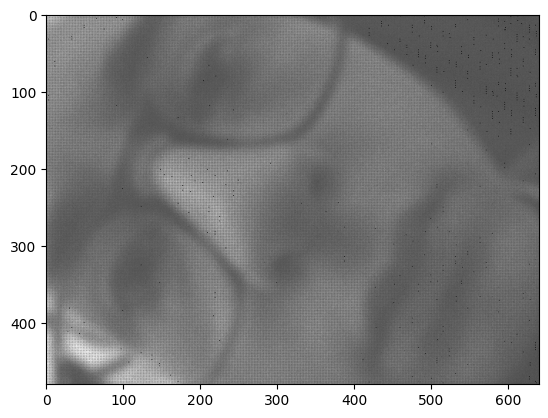

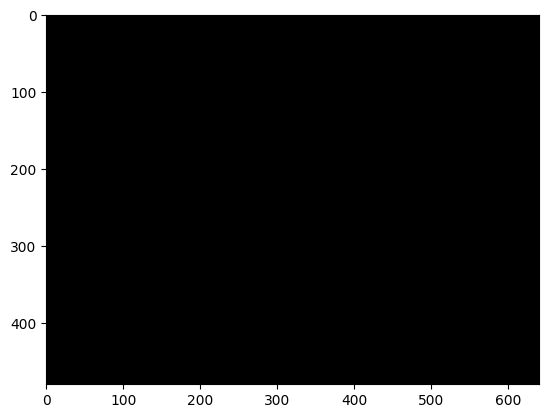

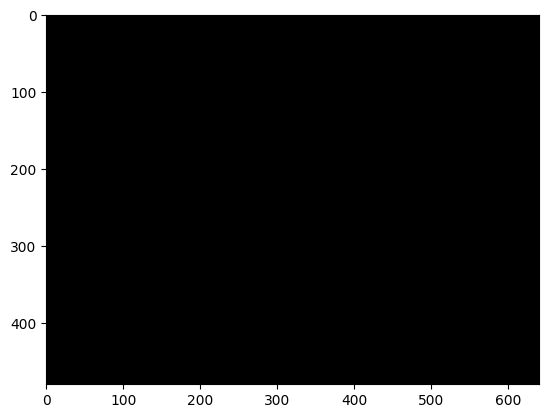

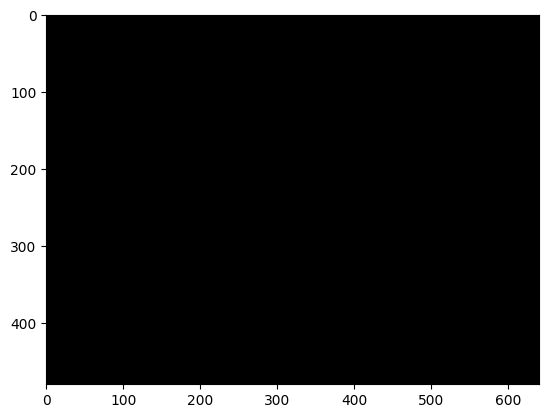

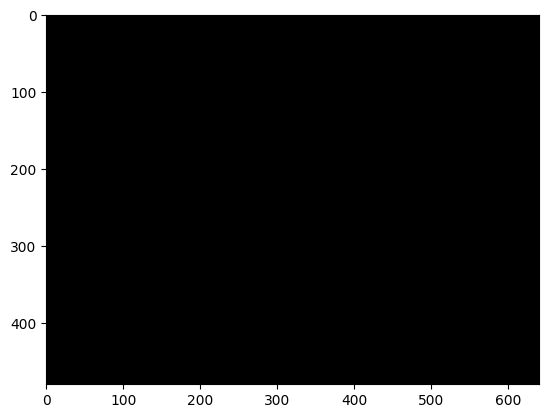

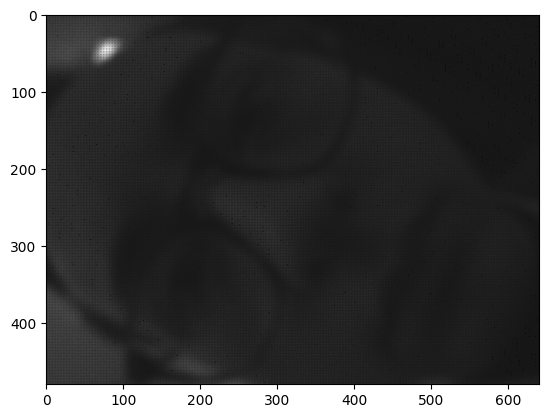

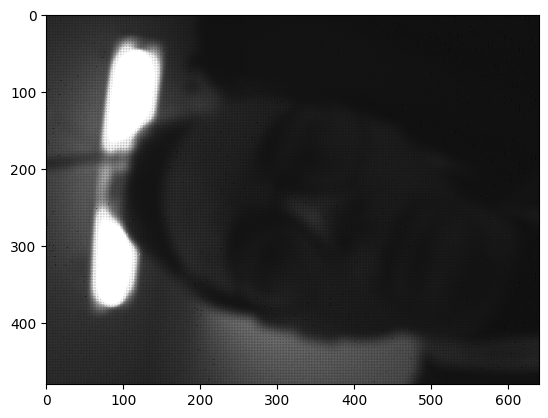

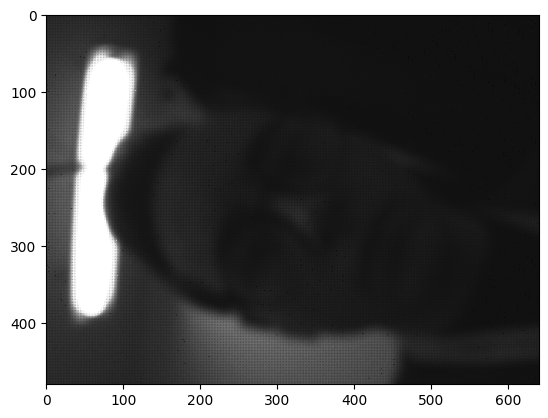

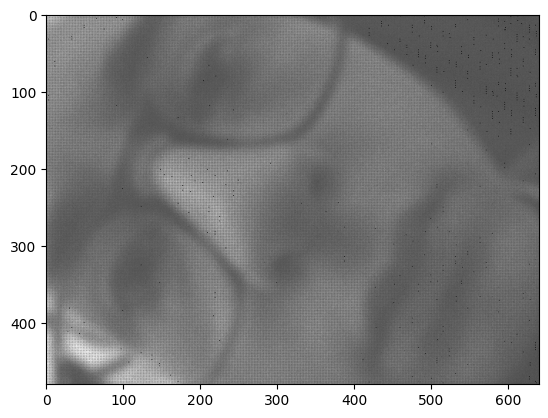

In [3]:
performance_df: pd.DataFrame = results['performance_df']
chunks: list = results['chunks']

# Iterate over the chunks 
for chunk in chunks:

    # Retrieve the difference sensors' data 
    #ms_data: tuple = chunk['M'] 
    world_data: np.ndarray = chunk['W']
    #pupil_data: list = chunk['P']
    #sunglasses_data: np.ndarray = chunk['S']

    #print(world_data.shape)
    #print(pupil_data.shape)
    for i in range(100, 200, 25):
        plt.imshow((world_data[i]), cmap='gray')
        plt.show()

        plt.hist(world_data[i].flatten())
        plt.show()

